### 循环神经网络

### RNN Layer的使用

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
rnn = nn.RNN(100, 10) 
# (word vec, dim) 编码方式为100维，10维表示memory或者说是h
rnn._parameters.keys()

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'])

In [3]:
# l0表示layer 0, 第0层.
rnn.weight_hh_l0.shape, rnn.weight_ih_l0.shape # (10, 10) (10, 100)

(torch.Size([10, 10]), torch.Size([10, 100]))

In [4]:
rnn.bias_hh_l0.shape, rnn.bias_ih_l0.shape # (10) (10)

(torch.Size([10]), torch.Size([10]))

nn.`RNN`(input_size=100, hidden_size=20, num_layers=1)  

`input_size`:编码方式的维度数量  
`hidden_size`:描述memory或者是hidden state的维度数量  
`num_layers`:默认是1。number of recurrent num_layers  

out, ht = forward(x, h0)  

`x`:\[seq len, b, word vec\]  
`ho/ht`:\[num layers, b, h dim\], 最后一个时间戳所有层的memory的信息。\[1, 3, 20\]  
`out`:\[seq len, b, h dim\], 每个时间戳最后一层（h0,h1,h2...）最后一个ht的状态。\[5, 3, 20\]  

In [5]:
rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=1)
print(rnn)
x = torch.randn(10, 3, 100) # [seq len, b, word vec]
out, h = rnn(x, torch.zeros(1, 3, 20)) # 传入的torch.zeros(1, 3, 20)是h0.
# out, h = rnn(x)
print(out.shape, h.shape)

RNN(100, 20)
torch.Size([10, 3, 20]) torch.Size([1, 3, 20])


当有两层时：  
ht = \[2, 3, 20\], 随层数变化  
out = \[5, 3, 20\], 不变

In [6]:
rnn = nn.RNN(input_size=100, hidden_size=10, num_layers=2)
rnn._parameters.keys()

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0', 'weight_ih_l1', 'weight_hh_l1', 'bias_ih_l1', 'bias_hh_l1'])

In [7]:
rnn.weight_hh_l0.shape, rnn.weight_ih_l0.shape

(torch.Size([10, 10]), torch.Size([10, 100]))

In [8]:
rnn.weight_hh_l1.shape, rnn.weight_ih_l1.shape

(torch.Size([10, 10]), torch.Size([10, 10]))

In [9]:
rnn = nn.RNN(input_size=100, hidden_size=20, num_layers=4)
print(rnn)
x = torch.randn(10, 3, 100)
out, h = rnn(x)
print(out.shape, h.shape) # [10, 3, 20] [4, 3, 20]

RNN(100, 20, num_layers=4)
torch.Size([10, 3, 20]) torch.Size([4, 3, 20])


### RNNCell与RNN的区别

RNNCell：不会循环T次  
RNN：加入循环T次  
初始化参数一样，forward参数不一样  

`ht = rnncell(xt, ht_1)`  

xt:\[b, word vec\]  
ht_1/ht:\[num layers, b, h dim\]  
out = torch.stack(\[h1, h2,...,ht\])

In [10]:
x = torch.randn(10, 3, 100)
cell1 = nn.RNNCell(input_size=100, hidden_size=20)
h1 = torch.zeros(3, 20)
for xt in x: # xt [3, 100]
    h1 = cell1(xt, h1)
print(h1.shape) # []

torch.Size([3, 20])


In [11]:
cell1 = nn.RNNCell(100, 30) # 把100的input变为30的memory
cell2 = nn.RNNCell(30, 20)
h1 = torch.zeros(3, 30)
h2 = torch.zeros(3, 20)
for xt in x:
    h1 = cell1(xt, h1)
    h2 = cell2(h1, h2)
print(h2.shape)

torch.Size([3, 20])


### 时间序列预测实战

In [12]:
num_time_steps = 50
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.01

In [15]:
class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True, # [b, seq len, word vec]
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_prev):
        # out:[b, seq len, hidden]
        # hidden_prev:[b, 1层, h]
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] -> [seq, h]
        out = out.view(-1, hidden_size)
        out = self.linear(out) # [seq, h] -> [seq, 1]
        out = out.unsqueeze(dim=0) # -> [1, seq, 1] 和y比较做均方差
        return out, hidden_prev

In [16]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size)

for iter in range(6000):
    start = np.random.randint(3, size=1)[0]
    time_steps = np.linspace(start, start+10, num_time_steps)
    data = np.sin(time_steps)
    data = data.reshape(num_time_steps, 1)
    x = torch.tensor(data[:-1]).float().view(1, num_time_steps-1, 1)
    y = torch.tensor(data[1:]).float().view(1, num_time_steps-1, 1)

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print("Iteration: {} loss {}".format(iter, loss.item()))



Iteration: 0 loss 0.4820752739906311
Iteration: 100 loss 0.002535458654165268
Iteration: 200 loss 0.008622479625046253
Iteration: 300 loss 0.0018586385995149612
Iteration: 400 loss 0.00041242362931370735
Iteration: 500 loss 0.0008607921772636473
Iteration: 600 loss 0.001343193813227117
Iteration: 700 loss 0.000715150497853756
Iteration: 800 loss 0.0014985622838139534
Iteration: 900 loss 0.00047577283112332225
Iteration: 1000 loss 0.0006612268043681979
Iteration: 1100 loss 0.0005459906533360481
Iteration: 1200 loss 0.0009342508856207132
Iteration: 1300 loss 0.0017088368767872453
Iteration: 1400 loss 0.0005086566088721156
Iteration: 1500 loss 0.00044047634582966566
Iteration: 1600 loss 0.0010506599210202694
Iteration: 1700 loss 0.0006036600098013878
Iteration: 1800 loss 0.0009934697300195694
Iteration: 1900 loss 0.00011338560580043122
Iteration: 2000 loss 0.0005401273956522346
Iteration: 2100 loss 0.0010527617996558547
Iteration: 2200 loss 0.0006973988492973149
Iteration: 2300 loss 0.000

In [17]:
start = np.random.randint(3, size=1)[0]
time_steps = np.linspace(start, start + 10, num_time_steps)
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)

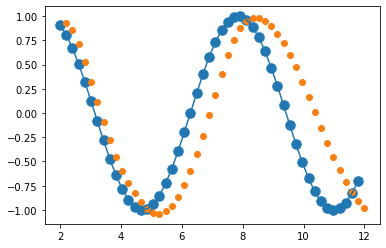

In [18]:
predictions = []
input = x[:, 0, :]
for _ in range(x.shape[1]):
    input = input.view(1, 1, 1)
    (pred, hidden_prev) = model(input, hidden_prev)
    input = pred
    predictions.append(pred.detach().numpy().ravel()[0])

x = x.data.numpy().ravel() # 多维转换为1维
y = y.data.numpy()
plt.scatter(time_steps[:-1], x.ravel(), s=90)
plt.plot(time_steps[:-1], x.ravel())

plt.scatter(time_steps[1:], predictions)
plt.show()